# Quantum Transfer Learning

First we need to load image datasets. Torchvision library is used to load the image datasets.

In [1]:
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "l"

In [2]:
n_qubits = 4
steps = 0.0004
batch_size = 4
num_epochs = 1
q_depth = 6
gamma_lr_scheduler = 0.1
q_delta = 0.01
start_time = time.time()

In [3]:
dev = qml.device("default.qubit", wires = n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
#cuda is used if available. Cpu is used instead.

In [4]:
data_transform = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]          
        ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transform[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True)
    for x in ["train", "validation"]
}

def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torchvision/transforms/functional.py:100: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  img = img.permute((2, 0, 1)).contiguous()
/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torchvision/transforms/functional.py:102: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  return img.float().div(255)
/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torchvision/transforms/functional.py:273: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  tensor = ten

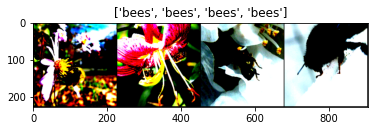

In [5]:
inputs, classes = next(iter(dataloaders["validation"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True)
    for x in ["train", "validation"]
}

### 1. Variational Quantum Circuit

In [6]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires = idx)

# Similar to Angle Embedding
def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires = idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires = [i,i+1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires = [i,i+1])

In [7]:
@qml.qnode(dev, interface = "torch", diff_method = "parameter-shift")
def quantum_net(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    H_layer(n_qubits)
    RY_layer(q_input_features)
    
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])
        
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [11]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [13]:
model_hybrid = torchvision.models.resnet18(pretrained = True)

for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.fc = DressedQuantumNet()
model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/tak/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torch/nn/modules/module.py:982: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  param.copy_(input_param)


In [14]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr = steps)

In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size = 10, gamma = gamma_lr_scheduler)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [19]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:


/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torch/nn/functional.py:2058: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  training, momentum, eps, torch.backends.cudnn.enabled
/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torch/nn/functional.py:1134: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  result = torch.relu_(input)
/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torch/nn/functional.py:586: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  input, kernel_size, stride, padding, dil

/Users/tak/anaconda3/envs/QC/lib/python3.7/site-packages/torch/optim/functional.py:94: UserWarning: Invalid OMP_NUM_THREADS variable value, stoi: no conversion (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/aten/src/ATen/ParallelCommon.cpp:38.)
  denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)


Phase: train Epoch: 1/1 Loss: 0.6606 Acc: 0.6107        
Phase: validation   Epoch: 1/1 Loss: 0.5631 Acc: 0.7974        
Training completed in 1m 31s
Best test loss: 0.5631 | Best test accuracy: 0.7974


In [20]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

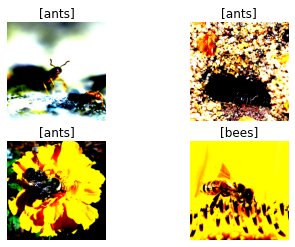

In [23]:
visualize_model(model_hybrid, num_images = batch_size)
plt.show()